In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Импортируем все датасеты. Сразу приводим ячейки с датами к формату datetime.

olist_customers_dataset   = pd.read_csv('olist_customers_dataset.csv',
                                        encoding='windows-1252', sep=',')

olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv',
                                        encoding='windows-1252', sep=',',
                                        parse_dates=['shipping_limit_date'])

olist_orders_dataset      = pd.read_csv('olist_orders_dataset.csv',
                                        encoding='windows-1252', sep=',',
                                        parse_dates=['order_purchase_timestamp',
                                                     'order_approved_at',
                                                     'order_delivered_carrier_date',
                                                     'order_delivered_customer_date',
                                                     'order_estimated_delivery_date'])

In [3]:
# В датафрейме olist_orders_dataset есть доставленные заказы, без даты доставки (order_delivered_customer_date)
olist_orders_dataset[(olist_orders_dataset.order_status == 'delivered') &
                     (olist_orders_dataset.order_delivered_customer_date.isna())]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


In [4]:
# Исследовать датасет и определить, какой вид заказа будет учитываться в retention

# Для подсчета показателя Retention можно использовать только заказы со статусом delivered
# Однако заказы с другим статусом тоже показывают то, что пользователь пользуется сорвисом
# Следовательно, я решил убрать из датасета только те заказы, которы были отменены по любой причине
# и те, которые еще не подтверждены. Все остальные заказы считаю валидными.

olist_orders_dataset_filtred = olist_orders_dataset[olist_orders_dataset.order_status \
                                                    .isin(['approved',
                                                           'invoiced',
                                                           'processing',
                                                           'shipped',
                                                           'delivered'])]

# Притягиваем customer_unique_id чтобы определить кто из клиентов делал заказ больше одного раза.

retention_df = olist_orders_dataset_filtred[['customer_id', 'order_purchase_timestamp']] \
        .merge(olist_customers_dataset[['customer_id', 'customer_unique_id']], on='customer_id')

In [5]:
# Добавляем поля, месяц и дата заказа
retention_df['order_period_month'] = retention_df.order_purchase_timestamp.dt.to_period('M')
retention_df['order_period_day'] = retention_df.order_purchase_timestamp.dt.to_period('D')

In [6]:
# Добавляем поля, месяц и дата первого заказа для каждого клиента отдельно
retention_df['cohort'] = retention_df.groupby('customer_unique_id')['order_purchase_timestamp'] \
        .transform('min').dt.to_period('M')
retention_df['cohort_day'] = retention_df.groupby('customer_unique_id')['order_purchase_timestamp'] \
        .transform('min').dt.to_period('D')

In [7]:
# расчитываем period прошедшый от первого до нынешнего заказа для каждого клиента
retention_df['period_month'] = np.floor((retention_df.order_period_day - retention_df.cohort_day).apply(lambda x: x.n ) / 30)

In [8]:
# Агрегируем данные и формируем сводную таблицу
cohort_df = retention_df.groupby(['cohort', 'period_month']).agg(n_customers=('customer_id', 'count')).reset_index()
cohort_pivot = cohort_df.pivot(index='cohort', columns='period_month', values='n_customers')

In [19]:
# Переводим сводную таблицу в процентное соотношение 
cohort_size = cohort_pivot.loc[:,0]
cohort_pivot_perc = cohort_pivot.divide(cohort_size, axis=0).loc[:,1:]
cohort_pivot_perc

period_month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,NaN,NaN,NaN,NaN,NaN,0.003413,NaN,NaN,0.003413,NaN,0.003413,NaN,0.003413,NaN,0.003413,NaN,0.003413,0.006826,0.003413,0.003413
2016-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,0.002535,NaN,0.005070,0.001267,0.001267,0.002535,0.002535,NaN,NaN,0.005070,0.005070,0.003802,0.002535,NaN,0.002535,0.002535,0.002535,0.001267,NaN,NaN
2017-02,0.001746,0.001746,0.003492,0.002328,0.001164,0.002910,0.000582,0.001164,0.002328,0.000582,0.003492,0.000582,0.001746,0.001164,0.000582,0.001164,0.002328,NaN,NaN,NaN
2017-03,0.002671,0.005341,0.004578,0.001145,0.000763,0.003434,0.001908,0.002671,0.002289,0.002289,0.001908,0.001908,0.001145,0.002671,0.000763,0.001145,0.001145,NaN,NaN,NaN
2017-04,0.003804,0.002959,0.000423,0.002959,0.003804,0.002536,0.004227,0.002113,0.002536,0.000845,0.001691,NaN,0.000845,0.000845,0.000845,0.001268,NaN,NaN,NaN,NaN
2017-05,0.004143,0.004695,0.003314,0.004143,0.003866,0.003590,0.001105,0.003038,0.002762,0.002209,0.003038,0.002209,0.001105,0.002486,0.001657,NaN,NaN,NaN,NaN,NaN
2017-06,0.003790,0.004738,0.003474,0.001263,0.005054,0.002843,0.001895,0.001263,0.003474,0.002527,0.002527,0.000632,0.002843,0.000948,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Определяем медианное значение за первый месяц
first_cohort_median = np.median(cohort_pivot_perc.fillna(0).loc[:,])
first_cohort_median

0.0022143489813994687

In [21]:
# Определяем  максимальное значение retention и когорту на 3-й месяц
period = cohort_pivot_perc.loc[:,3].idxmax()
max_value = cohort_pivot_perc.loc[:,3].max()

In [23]:
print(f'Медианное значение удержания за первый месяц равно {round(first_cohort_median, 4)}')
print(f'Максимальное значение удержания : {round(max_value,4)} наблюдается в когорте : {period}')

Медианное значение удержания за первый месяц равно 0.0036
Максимальное значение удержания : 0.0051 наблюдается в когорте : 2017-01


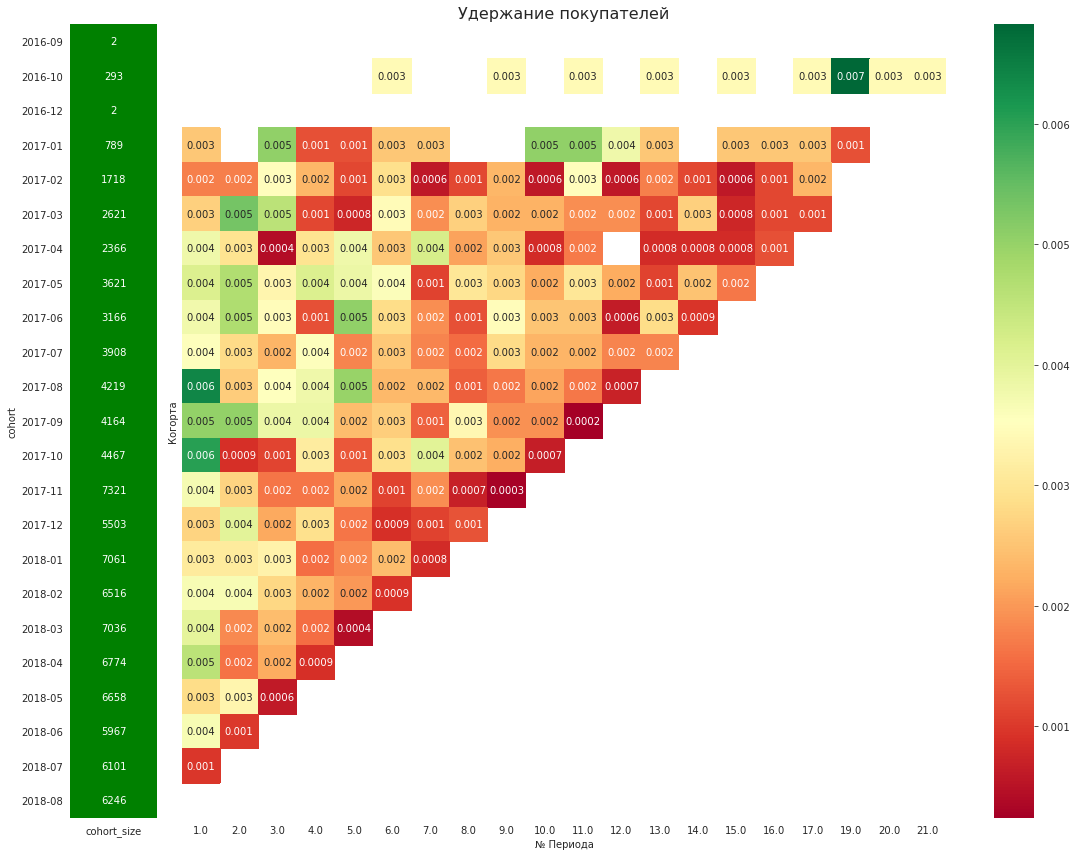

In [13]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(cohort_pivot_perc,
                mask=cohort_pivot_perc.isnull(),
                annot=True,
                fmt='.0000',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Удержание покупателей', fontsize=16)
    ax[1].set(xlabel='№ Периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['green'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()